In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [23]:
def parse_files(root_path):
    files = root_path.joinpath("./outputs").glob("*.json")
    f1_results = []
    per_problem_results = []

    for file in files:

        file_data = json.loads(file.read_text())
        original_target = root_path.joinpath(file_data["original_target"])
        original_dict = json.loads(Path(original_target).read_text())

        f1_scores = file_data['f1_scores']

        for problem in file_data['per_problem'].keys():

            perf_per_fold = file_data['per_problem'][problem]
            for fold_performance in perf_per_fold:
                perf_per_fold = {**fold_performance, **original_dict, 'problem': problem}
                per_problem_results += [perf_per_fold]

        for fold, score in enumerate(f1_scores):
            results_dict = {
                "f1": score,
                "fold": fold,
            }

            results_dict = {**results_dict, **original_dict}

            f1_results.append(results_dict)

    results_df = pd.DataFrame(f1_results)
    per_problem_df = pd.DataFrame(per_problem_results)
    # print(per_problem_df)

    return results_df, per_problem_df


In [24]:
data, per_problem = parse_files(Path('./analysis'))

# Visualisations

In [12]:
def label_ewma_and_gradients(df):
    def label(ewma, gradient):
        if ewma and gradient:
            return 'Both'
        elif ewma:
            return 'EWMA'
        elif gradient:
            return 'Gradient'
        else:
            return 'Neither'

    df['params_label_ewma_gradient'] = df.apply(lambda x: label(x['use_ewma'], x['use_gradient']), axis=1)
    return df

/tmp/ipykernel_2350/3698265629.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['params_label_ewma_gradient'] = df.apply(lambda x: label(x['use_ewma'], x['use_gradient']), axis=1)


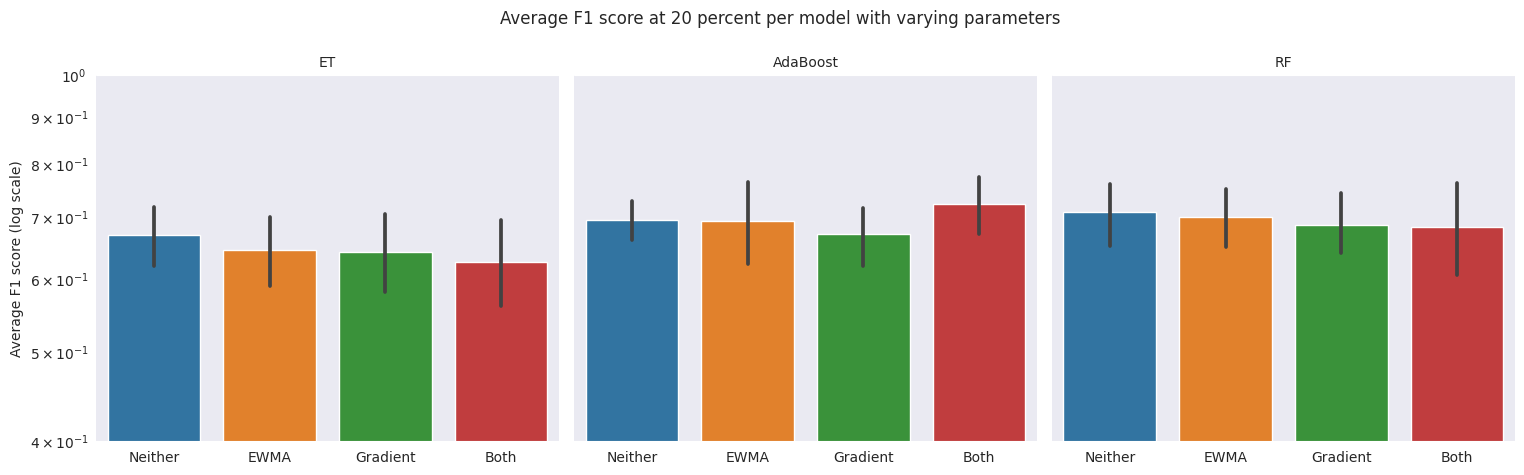

In [368]:
def plot_average_performance_at_x_percent(data_df, x):
    at_x_percent = data_df[data_df['percentage'] == x]
    trees_only = at_x_percent[at_x_percent['model'].isin(['RF', 'AdaBoost', 'ET'])]
    labels_added = label_ewma_and_gradients(trees_only)

    # print(trees_only)
    g = seaborn.catplot(data=labels_added, errorbar=('ci', 90), x='params_label_ewma_gradient', y='f1', col='model',
                        kind='bar', order=['Neither', 'EWMA', 'Gradient', 'Both'])
    for ax in g.axes.flat:
        ax.set(yscale="log")

    plt.ylim(0.4, 1)
    g.set_axis_labels("", "Average F1 score (log scale)")
    g.set_titles("{col_name}")
    g.despine(left=True)

    plt.suptitle(f"Average F1 score at {x} percent per model with varying parameters")
    plt.subplots_adjust(top=0.85)

    # Show the plot
    plt.show()


plot_average_performance_at_x_percent(data, 20)

/tmp/ipykernel_2350/3698265629.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['params_label_ewma_gradient'] = df.apply(lambda x: label(x['use_ewma'], x['use_gradient']), axis=1)


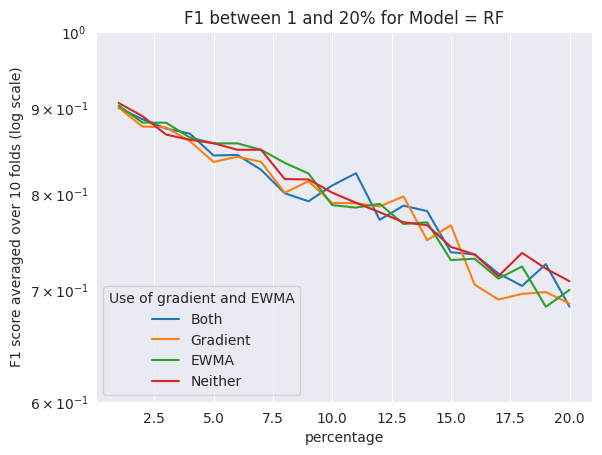

In [395]:
def plot_average_performance_between_percentages_inclusive(data_df, model, min_p, max_p):
    model_only = data_df[data_df['model'] == model]

    labels_added = label_ewma_and_gradients(model_only)
    labels_added = labels_added[
        labels_added['params_label_ewma_gradient'].isin(['Both', 'Neither', 'EWMA', 'Gradient'])]

    seaborn.lineplot(data=labels_added, x='percentage', y='f1', hue='params_label_ewma_gradient', errorbar=None).set(
        title=f"F1 between {min_p} and {max_p}% for Model = {model}",
        ylabel="F1 score averaged over 10 folds (log scale)", yscale='log')
    plt.legend(title='Use of gradient and EWMA', loc='lower left')

    plt.ylim(0.6, 1)


plot_average_performance_between_percentages_inclusive(data, 'RF', 1, 20)

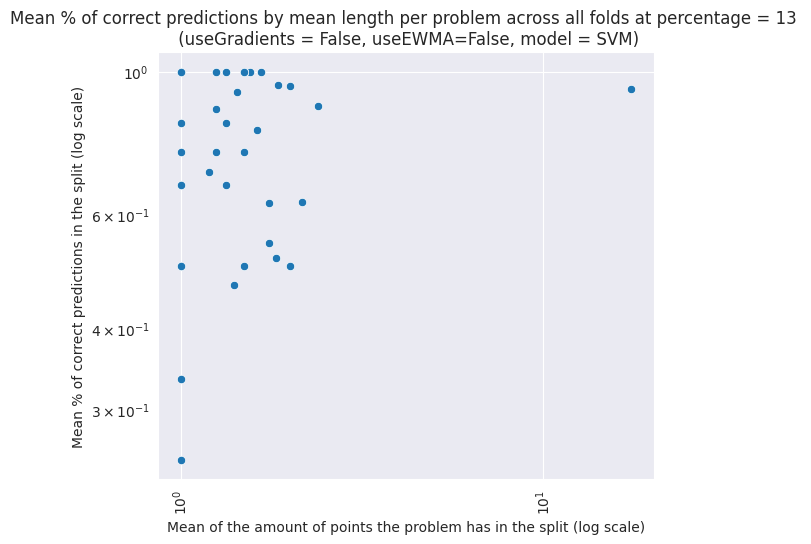

In [396]:
def scatterplot_length_vs_correct_per_problem(data_df, model, use_ewma, use_gradient):
    x = 5
    model_only = data_df[
        (data_df['percentage'] == x) & (data_df['model'] == model) & (data_df['use_ewma'] == use_ewma) & (
                data_df['use_gradient'] == use_gradient)]
    d = model_only.groupby(['problem'])[['length', 'correct']].mean()

    ax = seaborn.scatterplot(d, x='length', y='correct').set(
        title=f"Mean % of correct predictions by mean length per problem across all folds at percentage = {x} \n (useGradients = {use_gradient}, useEWMA={use_ewma}, model = {model})",
        ylabel="Mean % of correct predictions in the split (log scale)",
        xscale='log',
        yscale='log',
        xlabel="Mean of the amount of points the problem has in the split (log scale)")

    plt.xticks(rotation=90)

    plt.subplots_adjust(top=1)
    plt.show()


scatterplot_length_vs_correct_per_problem(per_problem, 'SVM', False, False)

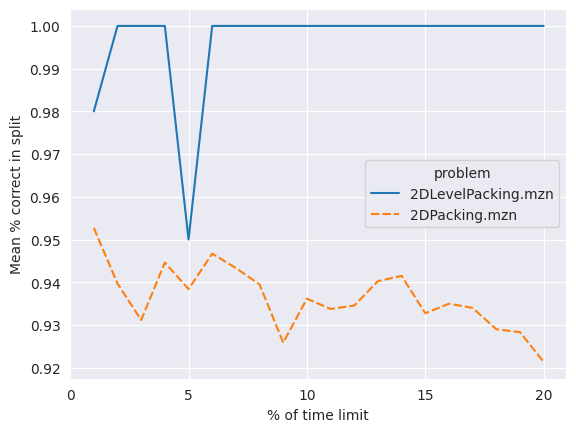

In [405]:
def line_graph_problem_vs_percentage(df, model, use_ewma, use_gradient):
    model_only = df[(df['model'] == model) & (df['use_ewma'] == use_ewma) & (df['use_gradient'] == use_gradient)]
    # Assuming you have the pivot table named 'pivot_table'
    pivot_table = model_only.pivot_table(index='percentage', columns='problem', values='correct', aggfunc='mean').iloc[
                  :, 0:5]

    ax = seaborn.lineplot(data=pivot_table, legend=True).set(
        ylabel="Mean % correct in split",
        xlabel="% of time limit",
        xticks=list(range(0,21, 5))
    )

    # Show the plot
    plt.show()


# print(pivot_table)


#
# plt.xticks(rotation=90)
# plt.subplots_adjust(top=1)
# plt.show()
#


line_graph_problem_vs_percentage(per_problem, 'SVM', False, False)